In [202]:
import tensorflow as tf
from tensorflow.estimator import DNNRegressor, LinearRegressor 

import keras
from keras.layers import Dense, add, Input
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping 

from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
import matplotlib.pyplot as plt

early_stopping_monitor = EarlyStopping(patience=5)

# 1 - Deep learning models with keras
- deep networks: many layers, capture a lot of interactions and partially reduce the need for feature engineering
- deep learning also called representation learning because subsequent layers build increasingly more sophisticated representations of the data
- with images, first layers identify simple patterns, subsequent layers combine those to identify complex objects

- nodes and weights:
  - each node represents interactions between certain input features or nodes in previous layers (the more nodes, the more interactions we capture)
  - each line has a weight (represent coefficients in regression) reflecting how much the input affects the hidden node that the line ends at

4 steps:
- specify architecture: how many layers, how many nodes in each layer (nodes in input just given by data), activation function in each layer
  - sequential: layers connect to layers directly after
  - dense: all nodes in previous layer connect with all nodes in new layer
  - input_shape = (n_cols,) n_cols and any number of rows
- compile: specify loss function (MSE is default for regression) and optimization (Adam is a good first choice, adaptive moment estimation)
- fit: cycle of back propagation and update of model weights with data
  - batches: chuncks of data, epochs: number of times trained on all batches
- predict

### 1.1 - activation function
- activation functions: non linearity between features and targets - act on node values (not weights)
- sigmoid: binary classification
- ReLu (rectified linear unit): hidden layers,  =max(0,X)
- **for regression use 'relu' in hidden layers, nothing in output layer**
- **for classification use 'relu' in hidden layers, 'softmax' in output layer with >2 classes otherwise sigmoid**
  
- critical and may cause dying neuron: neuron takes values <0 for all rows of data, so slopes are 0 and weights don't get updated 
  - can be corrected with activation functions for which slopes are small but never zero which works with a few layers
  - for many layers this causes vanishing gradient problem, they get very close to zero with backprop
  - non flat below zero don't seem to work

  

  

<img src="./img/activation_functions.png" align="left" style="width: 400px;"/>

### 1.2 - Optimizing a neural network: backward propagation
- gradient descent: update weights by slope*learning rate (tipically lr=0.01, small steps to make sure we keep moving down)
- calculated using: input value into the node, slope of loss function with respect to each weight (found by comparing output with target), slope of activation function
- back propagation: update weights backwards from output
  - first do forward propagation to compute error, then do back propagation
  - by the time we do back propagation the slope of loss function has been calculated
- normally calculate slopes in batches for each update of the weights (stochastic gradients descent, SGD), when all batches have been used 1 epoch is completed

**Optimizers**:
- Stocastic Gradient Descent (SGD): fast and avoids getting stuck in local minimum
  - learning rate: 0.01 - 0.5 (higher learning rate, faster drop of ball, but it might miss global minima)
- Root mean square (RMS) propgation optimizer
  - different learning rates to each feature
  - decay parameter which helps escape local minimum
- Adaptive momentum optimizer (Adam)
  - beta1 and beta2 parameters, increase to lower chance of getting stuck on local minimum

### 1.3 - Trainning (initializer and dropout)
- Dense layers are initialized with glorot initializer by default: initialize thousands of variables randomly to avoid local minimum
  - alternatively specify tf.keras.layers.Dense(..., kernel_initializer='zeros')
- avoid overfitting: memorize points instead of learning pattern
  - dropout, randomly drop nodes from a layer: more robust classification that does not rely on particular nodes 

### 1.4 - Model or Network capacity: validation score
- ability to find predictive patterns in data 
- create a small network then keep adding capacity as long as score keeps improving
  - increase number of hidden layers or number of hidden nodes (start with nodes)

<img src='./img/bias_variance.png' align='left' style="width: 500px;">

### 1.5 - Neural Nets with Keras: 

- Sequential API: input layer, hidden layers, output layers in sequence (don't need to pass layers into next ones)

In [175]:
model = Sequential()

model.add(Dense(16, activation='relu', input_shape=(2,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile('adam', loss='categorical_crossentropy')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_477 (Dense)            (None, 16)                48        
_________________________________________________________________
dense_478 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_479 (Dense)            (None, 4)                 36        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
None


- Functional API: two models with different inputs

In [176]:
m1_inputs = Input(shape=(2,))
m1_layer1 = Dense(12, activation='sigmoid')(m1_inputs)
m1_layer2 = Dense(4, activation='softmax')(m1_layer1)

m2_inputs = Input(shape=(2,))
m2_layer1 = Dense(8, activation='relu')(m2_inputs)
m2_layer2 = Dense(4, activation='softmax')(m2_layer1)

merged = add([m1_layer2, m2_layer2])
model = Model(inputs=[m1_inputs, m2_inputs], outputs=merged)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
dense_480 (Dense)               (None, 12)           36          input_15[0][0]                   
__________________________________________________________________________________________________
dense_482 (Dense)               (None, 8)            24          input_16[0][0]                   
__________________________________________________________________________________________________
dense_481 

<br>

## 2 - Regression problem to predict hourly_wages: 
- optimizer='adam'

In [158]:
df = pd.read_csv('./data/hourly_wages.csv')
train_df = df[:int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

train_features_df = train_df.drop('wage_per_hour', axis=1)
train_target_df = train_df['wage_per_hour']

test_features_df = test_df.drop('wage_per_hour', axis=1)
test_target_df = test_df['wage_per_hour']

n_features = features_df.shape[1]

In [160]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
#print("Loss function: " + model.loss)
model.fit(train_features_df, train_target_df, epochs=10, validation_split=0.3, verbose=False)
score = model.evaluate(test_features_df, test_target_df)

print(f"Evaluation score: {np.sqrt(score):0.2f}")

54/54 [==============================] - 0s 200us/step
Evaluation score: 5.91


<br>

## 3 - Binary Classification for Titanic survival: 
- loss='categorical_crossentropy', metrics=['accuracy']
- final layer needs one node for each outcome, with softmax activation (ensure predictions add up to one and can be interpreted as probabilities)

In [161]:
df = pd.read_csv('./data/titanic_all_numeric.csv')
train_df = df[:int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

train_features_df = train_df.drop('survived', axis=1)
train_target_df = to_categorical(train_df['survived'])

test_features_df = test_df.drop('survived', axis=1)
test_target_df = to_categorical(test_df['survived'])

n_features = features_df.shape[1]

### 3.1 - simple sequential model, fit, evaluate and predict

In [162]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(n_cols,)))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(train_features_df, train_target_df, epochs=10, verbose=False, validation_split=0.3, 
          callbacks=[early_stopping_monitor])
score = model.evaluate(test_features_df, test_target_df)
print(f"Evaluation accuracy: {score[1]:0.2f}")

model.save('./models/titanic_model.h5')

predictions = model.predict(predictors)
predicted_prob_true = predictions[:,1]

# print predicted_prob_true
print(predicted_prob_true[:5])

90/90 [==============================] - 0s 200us/step
Evaluation accuracy: 0.66
[0.2000058  0.5054923  0.22789302 0.4535593  0.13145064]


### 3.2 - Learning Rate

In [163]:
def get_new_model(input_shape):

    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return (model)

lr_to_test = [0.000001, 0.01, 1]

# Loop over learning rates
for lr in lr_to_test:
    print('\nTesting model with learning rate: %f'%lr )
    
    model = get_new_model((n_cols,))   
    model.compile(optimizer=SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])    
    model.fit(train_features_df, train_target_df, epochs=10, verbose=False, validation_split=0.3, 
              callbacks=[early_stopping_monitor])
    score = model.evaluate(test_features_df, test_target_df, verbose=False)
    print(f"Evaluation accuracy: {score[1]:0.2f}")
    


Testing model with learning rate: 0.000001
Evaluation accuracy: 0.38

Testing model with learning rate: 0.010000
Evaluation accuracy: 0.62

Testing model with learning rate: 1.000000
Evaluation accuracy: 0.62


### 3.3 - Validation
- k-fold is uncommon because data is very large
- earlystopping patience: how many epochs the model can go without imporving before we stop trainning

Evaluation accuracy model 1: 0.71
Evaluation accuracy model 2: 0.74


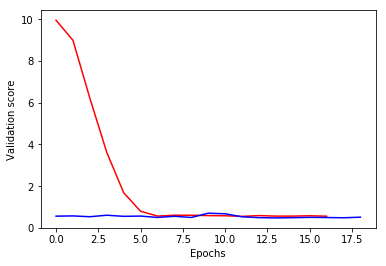

In [164]:
#model_1
model_1 = Sequential()
model_1.add(Dense(10, activation='relu', input_shape = (n_cols,)))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

#model_2
model_2 = Sequential()
model_2.add(Dense(50, activation='relu', input_shape = (n_cols,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(2, activation='softmax'))


model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1_training = model_1.fit(train_features_df, train_target_df, epochs=20, validation_split=0.3, 
                               callbacks=[early_stopping_monitor], verbose=False)
model_2_training = model_2.fit(train_features_df, train_target_df, epochs=20, validation_split=0.3, 
                               callbacks=[early_stopping_monitor], verbose=False)

score = model_1.evaluate(test_features_df, test_target_df, verbose=False)
print(f"Evaluation accuracy model 1: {score[1]:0.2f}")
score = model_2.evaluate(test_features_df, test_target_df, verbose=False)
print(f"Evaluation accuracy model 2: {score[1]:0.2f}")

# Create the plot
plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

<br>

## 4 - MultiClassification for Hand written numbers

In [165]:
df = pd.read_csv('./data/mnist.csv', header=None)
train_df = df[:int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

y_train  = to_categorical(train_df.iloc[:,0])
X_train = train_df.iloc[:,1:]

y_test  = to_categorical(test_df.iloc[:,0])
X_test = test_df.iloc[:,1:]

In [166]:
early_stopping_monitor = EarlyStopping(patience=5)

model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(784,)))
model.add(Dense(20, activation='relu', input_shape=(784,)))
model.add(Dense(20, activation='relu', input_shape=(784,)))
model.add(Dense(20, activation='relu', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train,y_train,validation_split=0.3, verbose=False, epochs=50, callbacks=[early_stopping_monitor])
score = model.evaluate(X_test, y_test, verbose=False)
print(f"Evaluation accuracy: {score[1]:0.2f}")

Evaluation accuracy model 2: 0.69


<br>

## 5 - MultiClassification for 4 signs from sign language
- dataset: 2000 sign language images (first column 0 to 3 to represent each of 4 signs), additional 784 columns represent 28x28 pixel image

In [178]:
early_stopping_monitor = EarlyStopping(patience=5)

df = pd.read_csv('./data/slmnist.csv', header=None, dtype=np.float64)

target_df = np.array(pd.get_dummies(df.iloc[:,0]))
features_df = df.iloc[:,1:]
features_df = pd.DataFrame(MinMaxScaler().fit_transform(features_df), columns=features_df.columns)

train_features_df = features_df[:int(len(features_df)*0.9)]
train_target_df = target_df[:int(len(target_df)*0.9)]

test_features_df = features_df[int(len(features_df)*0.9):]
test_target_df = target_df[int(len(target_df)*0.9):]

In [183]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(784,)))
model.add(Dense(4, activation='softmax'))

model.compile('SGD', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_features_df, train_target_df, validation_split=0.3, verbose=False, epochs=5, 
          callbacks=[early_stopping_monitor])

score = model.evaluate(test_features_df, test_target_df, verbose=False)
print(f"Evaluation train accuracy: {score[1]:0.2f}")
score = model.evaluate(train_features_df, train_target_df, verbose=False)
print(f"Evaluation test accuracy: {score[1]:0.2f}")

Evaluation train accuracy: 0.91
Evaluation test accuracy: 0.86


In [184]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(784,)))
model.add(Dense(4, activation='softmax'))

model.compile('SGD', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_features_df, train_target_df, validation_split=0.3, verbose=False, epochs=5, 
          callbacks=[early_stopping_monitor])

score = model.evaluate(test_features_df, test_target_df, verbose=False)
print(f"Evaluation train accuracy: {score[1]:0.2f}")
score = model.evaluate(train_features_df, train_target_df, verbose=False)
print(f"Evaluation test accuracy: {score[1]:0.2f}")

Evaluation train accuracy: 0.94
Evaluation test accuracy: 0.93


In [187]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(4, activation='softmax'))

model.compile('SGD', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_features_df, train_target_df, validation_split=0.3, verbose=False, epochs=5, 
          callbacks=[early_stopping_monitor])

score = model.evaluate(test_features_df, test_target_df, verbose=False)
print(f"Evaluation train accuracy: {score[1]:0.2f}")
score = model.evaluate(train_features_df, train_target_df, verbose=False)
print(f"Evaluation test accuracy: {score[1]:0.2f}")

Evaluation train accuracy: 0.95
Evaluation test accuracy: 0.95


In [193]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(784,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile('SGD', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_features_df, train_target_df, validation_split=0.3, verbose=False, epochs=5, 
          callbacks=[early_stopping_monitor])

score = model.evaluate(test_features_df, test_target_df, verbose=False)
print(f"Evaluation train accuracy: {score[1]:0.2f}")
score = model.evaluate(train_features_df, train_target_df, verbose=False)
print(f"Evaluation test accuracy: {score[1]:0.2f}")

Evaluation train accuracy: 0.86
Evaluation test accuracy: 0.84


<br>

## 6 - High level Estimators: predict House Prices 
- high level: Estimators - enforces best practices, faster deployment, less flexibility
- mid level: layers, datasets, metrics
- low level: python 

In [222]:
tf.logging.set_verbosity(0)

In [237]:
housing = pd.read_csv('./data/kc_house_data.csv')

bedrooms = tf.feature_column.numeric_column("bedrooms")
bathrooms = tf.feature_column.numeric_column("bathrooms")
sqft_living = tf.feature_column.numeric_column("sqft_living")

# Define the list of feature columns
feature_list = [bedrooms, bathrooms, sqft_living]

def input_fn():
    labels = np.array(housing['price'])
    features = {'bedrooms':np.array(housing['bedrooms']), 
                'bathrooms':np.array(housing['bathrooms']),
                'sqft_living':np.array(housing['sqft_living'])
               }
    return features, labels

In [254]:
model = DNNRegressor(feature_columns=feature_list, hidden_units=[4,200])
model_trainning = model.train(input_fn, steps=100)
score = model.evaluate(input_fn, steps=10)
print(score)
print(f"Mean error from evaluation: {np.sqrt(score['average_loss']):0.2f}")

{'average_loss': 68717790000.0, 'label/mean': 540088.1, 'loss': 1485197500000000.0, 'prediction/mean': 541660.4, 'global_step': 100}
Mean error from evaluation: 262140.78


In [255]:
model = tf.estimator.LinearRegressor(feature_columns=feature_list)
model_trainning = model.train(input_fn, steps=500)
score = model.evaluate(input_fn, steps=500)
print(score)
print(f"Mean error from evaluation: {np.sqrt(score['average_loss']):0.2f}")

{'average_loss': 403382400000.0, 'label/mean': 540087.25, 'loss': 8718303600000000.0, 'prediction/mean': 17955.258, 'global_step': 500}
Mean error from evaluation: 635123.94
